# [Advent of Code 2020](https://adventofcode.com/2020)
I'm going to have a go at the Advent of Code using a Jupyter Notebook. First, we'll import some modules.

In [1]:
# Standard imports
import cmath
import collections as cs
import dataclasses
import functools
import itertools as its
import math
import numbers
import operator as ops
import random
import re
import statistics
import string
import time
import typing
from pprint import pprint

# Non-standard imports
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import graphviz as gv

Next, some helper functions.

In [2]:
def day(day):
    'Load the input for `day`'
    return open(f'input/{day}').read()

flatten = its.chain.from_iterable
cat = ''.join
ncat = '\n'.join
first = ops.itemgetter(0)
second = ops.itemgetter(1)

def last(xs):
    'Return the last element of an iterable sequence'
    return cs.deque(iter(xs), maxlen=1)[0]

def ints(s):
    'Return a tuple of integer tokens in `s`'
    return tuple(int(x) for x in re.findall(r'[-+]?\d+', s))

def array(data):
    'Convert the data into a tuple of int-tuples'
    return tuple(ints(line) for line in data.splitlines())

def swap(xs, i, j):
    'Swap items in a sequence.'
    xs[i], xs[j] = xs[j], xs[i]

def nth(xs, n):
    'Return the nth element of a sequence.'
    return next(its.islice(xs, n, None))

def take(xs, n=None):
    'Return (up to) first `n` items of a sequence or the whole sequence if `n` is `None`'
    return list(its.islice(xs, n))

def overlapping(xs, n):
    '''Generate overlapping n-tuples from `xs`

    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG
    '''
    if isinstance(xs, cs.abc.Sequence):
        yield from (xs[i:i+n] for i in range(len(xs) + 1 - n))
    else:
        result = cs.deque(maxlen=n)
        for x in xs:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    's -> (s0,s1), (s1,s2), (s2, s3), ...'
    return overlapping(iterable, 2)

def powerset(xs):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(xs)
    return flatten(its.combinations(s, r) for r in range(len(s)+1))

def chunked(xs, n, extend=False, fillvalue=None):
    'Collect `xs` into chunks of length `n`'
    xss = [iter(xs)] * n
    if extend:
        return its.zip_longest(*xss, fillvalue=fillvalue)
    else:
        return zip(*xss)

def grouped(xs, key):
    return [list(g) for _, g in its.groupby(sorted(xs, key=key), key=key)]

def manhattan_distance(P, Q=None):
    'Return the city block distance from `P` to `Q`'
    if isinstance(P, numbers.Number):
        d = P if Q is None else P-Q 
        return math.fabs(d.real) + math.fabs(d.imag)
    elif Q is None:
        return sum(math.fabs(p) for p in P)
    else:
        return sum(math.fabs(p-q) for p,q in zip(P, Q))

def neighbours4(*v):
    'Return the horizontal and vertical neighbours of `(x, y)`'
    if len(v) == 1:
        c = v[0]
        return c-1j, c+1, c+1j, c-1
    else:
        x, y = v
        return (x,y-1),(x-1,y),(x+1,y),(x,y+1)

def neighbours8(x, y):
    'Return the horizontal, vertical and diagonal neighbours of `(x, y)`'
    return ((x-1,y-1),(x-1,y),(x-1,y+1),
            (x,y-1),          (x,y+1),
            (x+1,y-1),(x+1,y),(x+1,y+1))

def unique(xs):
    'Return `True` iff no elements of `xs` are repeated'
    return len(xs) == len(set(xs))

## Day 1: [Report Repair](https://adventofcode.com/2020/day/1)

Given a list of numbers, find the product of the pair which sum to 2020

In [3]:
pair = next(p for p in its.combinations(ints(day(1)), 2) if sum(p) == 2020)
math.prod(pair)

776064

For part two, we're asked for a triple rather than a pair.

In [4]:
triple = next(t for t in its.combinations(ints(day(1)), 3) if sum(t) == 2020)
math.prod(triple)

6964490

## Day 2: [Password Philosophy](https://adventofcode.com/2020/day/2)

We are asked to count valid passwords given a list of password specifications in the form:
```
1-3 a: abcde
1-3 b: cdefg
2-9 c: ccccccccc
```


In [5]:
# For part one, a password is valid if the frequency of the character 
# specified lies in the range specified
# E.g. `1-3 a: abcde` is fine since `a` appears once
spec_match = re.compile('(\d+)-(\d+) (\w): (\w+)$').match
    
def valid_password(spec):
    lo, hi, ch, pw = spec_match(spec).group(1, 2, 3, 4)
    return int(lo) <= pw.count(ch) <= int(hi)

assert valid_password('1-3 a: abcde')
assert not valid_password('1-3 b: cdefg')
assert valid_password('2-9 c: ccccccccc')

sum(valid_password(spec) for spec in day(2).splitlines())

515

In [6]:
# For part two, the numbers in the password spec are 1-based indices
# into the password, which is valid if exactly one of the characters 
# at these indices is the one specified.
def valid_password(spec):
    lo, hi, ch, pw = spec_match(spec).group(1, 2, 3, 4)
    return (pw[int(lo)-1] == ch) ^ (pw[int(hi)-1] == ch)

assert valid_password('1-3 a: abcde')
assert not valid_password('1-3 b: cdefg')
assert not valid_password('2-9 c: ccccccccc')

sum(valid_password(spec) for spec in day(2).splitlines())

711

## Day 3: [Toboggan Trajectory](https://adventofcode.com/2020/day/3)

Trees are the `#` in a grid as shown in the example. The grid tiles repeatedly to the right. 

```
..##.......
#...#...#..
.#....#..#.
..#.#...#.#
.#...##..#.
..#.##.....
.#.#.#....#
.#........#
#.##...#...
#...##....#
.#..#...#.#
```

Starting at the top-left corner of your map and following a slope of right 3 and down 1, how many trees would you encounter?

In [7]:
def steps(step):
    return zip(its.count(0, step[0]), its.count(0, step[1]))

def load_trees(data):
    return [[ch=='#' for ch in row] for row in data.splitlines()]

def count_trees_hit(trees, step=(3, 1)):
    depth, stride = len(trees), len(trees[0])
    return sum(trees[p[1]][p[0] % stride] 
               for p in its.takewhile(lambda p: p[1] < depth, steps(step)))

example3 = '''\
..##.......
#...#...#..
.#....#..#.
..#.#...#.#
.#...##..#.
..#.##.....
.#.#.#....#
.#........#
#.##...#...
#...##....#
.#..#...#.#
'''

assert count_trees_hit(load_trees(example3)) == 7
count_trees_hit(load_trees(day(3)))

207

For part two, we parametrise the step. We're asked how many trees are hit using a number of different step patterns, and to multiply these figures to produce a final answer.

In [8]:
step = ((1, 1), (3, 1), (5, 1), (7, 1), (1, 2))
trees = load_trees(example3)
assert math.prod([count_trees_hit(trees, s) for s in step]) == 336
trees = load_trees(day(3))
math.prod([count_trees_hit(trees, s) for s in step])

2655892800

## Day 4: [Passport Processing](https://adventofcode.com/2020/day/4)

We are asked to validate a list of passports according to some subtle rules.
For part 1, a password is valid if it has at all the required fields with the possible exception of `cid`.

In [9]:
example4 = '''\
ecl:gry pid:860033327 eyr:2020 hcl:#fffffd
byr:1937 iyr:2017 cid:147 hgt:183cm

iyr:2013 ecl:amb cid:350 eyr:2023 pid:028048884
hcl:#cfa07d byr:1929

hcl:#ae17e1 iyr:2013
eyr:2024
ecl:brn pid:760753108 byr:1931
hgt:179cm

hcl:#cfa07d eyr:2025 pid:166559648
iyr:2011 ecl:brn hgt:59in'''

required_fields = set('byr iyr eyr hgt hcl ecl pid'.split())

def valid_passport(passport_spec):
    fields = {w[:3] for w in passport_spec.split()}
    return not required_fields - fields

assert sum(valid_passport(pp) for pp in example4.split('\n\n')) == 2
sum(valid_passport(pp) for pp in day(4).split('\n\n'))

237

Part 2 makes the rules more complex.
You can continue to ignore the cid field, but each other field has strict rules about what values are valid for automatic validation:

- byr (Birth Year) - four digits; at least 1920 and at most 2002.
- iyr (Issue Year) - four digits; at least 2010 and at most 2020.
- eyr (Expiration Year) - four digits; at least 2020 and at most 2030.
- hgt (Height) - a number followed by either cm or in:
 - If cm, the number must be at least 150 and at most 193.
 - If in, the number must be at least 59 and at most 76.
- hcl (Hair Color) - a # followed by exactly six characters 0-9 or a-f.
- ecl (Eye Color) - exactly one of: amb blu brn gry grn hzl oth.
- pid (Passport ID) - a nine-digit number, including leading zeroes.
- cid (Country ID) - ignored, missing or not.

In [10]:
def valid_year(lo, hi):
    ys = {str(y) for y in range(lo, hi+1)}
    return lambda y: y in ys

def valid_height(h):
    v, units = h[:-2], h[-2:]
    try:
        return {
            'cm': int(v) in range(150, 194),
            'in': int(v) in range(59, 77),
        }[units]
    except (KeyError, ValueError):
        return False

field_validators = {
    'byr': valid_year(1920, 2002),
    'iyr': valid_year(2010, 2020),
    'eyr': valid_year(2020, 2030),
    'hgt': valid_height,
    'hcl': re.compile('#[0-9a-f]{6}$').match,
    'ecl': lambda v: v in 'amb blu brn gry grn hzl oth'.split(),
    'pid': re.compile('\d{9}$').match,
    'cid': lambda v: True
}

def valid_passport(passport_spec):
    fields = {w[:3]:w[4:] for w in passport_spec.split()}
    if required_fields - set(fields):
        return False
    else:
        return all(field_validators[k](v) for k, v in fields.items())

invalid_passports = '''\
eyr:1972 cid:100
hcl:#18171d ecl:amb hgt:170 pid:186cm iyr:2018 byr:1926

iyr:2019
hcl:#602927 eyr:1967 hgt:170cm
ecl:grn pid:012533040 byr:1946

hcl:dab227 iyr:2012
ecl:brn hgt:182cm pid:021572410 eyr:2020 byr:1992 cid:277

hgt:59cm ecl:zzz
eyr:2038 hcl:74454a iyr:2023
pid:3556412378 byr:2007
'''

valid_passports = '''\
pid:087499704 hgt:74in ecl:grn iyr:2012 eyr:2030 byr:1980
hcl:#623a2f

eyr:2029 ecl:blu cid:129 byr:1989
iyr:2014 pid:896056539 hcl:#a97842 hgt:165cm

hcl:#888785
hgt:164cm byr:2001 iyr:2015 cid:88
pid:545766238 ecl:hzl
eyr:2022

iyr:2010 hgt:158cm hcl:#b6652a ecl:blu byr:1944 eyr:2021 pid:093154719
'''

assert not any(valid_passport(pp) for pp in invalid_passports.split('\n\n'))
assert all(valid_passport(pp) for pp in valid_passports.split('\n\n'))

sum(valid_passport(pp) for pp in day(4).split('\n\n'))

172

## Day 5: [Binary Boarding](https://adventofcode.com/2020/day/5)

A seat on a plane has an id of the form `FBFBBFFRLR` where `F` and `B` indicate front and back, identifying row, `L` and `R` indicate column. The seat id is found by multiplying the row by 8 then adding the column.

In [11]:
# Convert the FBFBBFFRLR form into standard binary 0101100101 
# This number _is_ the id
table = str.maketrans('FBLR', '0101')
def seat_id(boarding_pass):
    return int(boarding_pass.translate(table), 2)

assert seat_id('FBFBBFFRLR') == 357
seats = {seat_id(p) for p in day(5).split()}
max(seats)

987

Part two asks which seat id is missing from the input, but says:
> some of the seats at the very front and back of the plane don't exist on this aircraft, so they'll be missing from your list as well ... the seats with IDs +1 and -1 from yours will be in your list."

In [12]:
set(range(min(seats), max(seats)+1)) - seats

{603}

## Day 6: [Custom Customs](https://adventofcode.com/2020/day/6)
Each person's set of answers is on a line. People are grouped. Groups are separated by a blank line. Part 1 asks us to count the number of questions anyone in a group answers "yes" to.

In [13]:
def answers(group):
    return [set(line) for line in group.splitlines()]

def total_anyone_answers_yes(all_answers):
    return sum(len(set.union(*answers(group))) 
               for group in all_answers.split('\n\n'))

example6 = '''\
abc

a
b
c

ab
ac

a
a
a
a

b'''

assert total_anyone_answers_yes(example6) == 11

total_anyone_answers_yes(day(6))

6443

 Part 1 asks us to count the number of questions _everyone_ in a group answers "yes" to.

In [14]:
def total_everyone_answers_yes(all_answers):
    return sum(len(set.intersection(*answers(group))) 
               for group in all_answers.split('\n\n'))

assert total_everyone_answers_yes(example6) == 6
total_everyone_answers_yes(day(6))

3232

## Day 7: [Handy Haversacks](https://adventofcode.com/2020/day/7)

This looks like a graph processing puzzle. We have some luggage processing rules, and we are asked:
> You have a shiny gold bag. If you wanted to carry it in at least one other bag, how many different bag colors would be valid for the outermost bag?

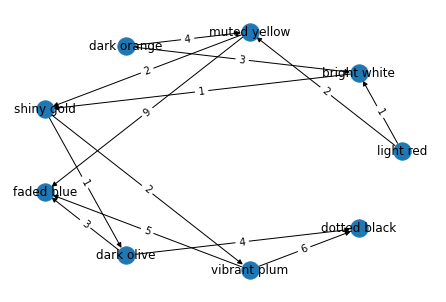

In [15]:
example7 = '''\
light red bags contain 1 bright white bag, 2 muted yellow bags.
dark orange bags contain 3 bright white bags, 4 muted yellow bags.
bright white bags contain 1 shiny gold bag.
muted yellow bags contain 2 shiny gold bags, 9 faded blue bags.
shiny gold bags contain 1 dark olive bag, 2 vibrant plum bags.
dark olive bags contain 3 faded blue bags, 4 dotted black bags.
vibrant plum bags contain 5 faded blue bags, 6 dotted black bags.
faded blue bags contain no other bags.
dotted black bags contain no other bags.'''

find_bags = re.compile('(\w+ \w+) bag').findall

def get_bags_graph(bag_rules):
    G = nx.DiGraph()
    for rule in bag_rules.splitlines():
        bag, *bags = find_bags(rule)
        counts = ints(rule)
        G.add_edges_from((bag, inner, {'weight': w})
                         for inner, w in zip(bags, counts))
    return G

def draw_bags(G):
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

exG = get_bags_graph(example7)
draw_bags(exG)

The first part of the puzzle asks how many bags colours can eventually contain at least one shiny gold bag?

In [16]:
assert len(nx.algorithms.dag.ancestors(exG, 'shiny gold'))
bagsG = get_bags_graph(day(7))
len(nx.algorithms.dag.ancestors(bagsG, 'shiny gold'))

238

Part two asks us to count the number of bags contained in the shiny gold bag.

In [17]:
@functools.lru_cache(maxsize=None)
def count_bags(G, bag):
    return sum(count_bags(G, b) * v['weight'] 
               for b, v in G[bag].items()) + 1

assert count_bags(exG, 'shiny gold') - 1 == 32
count_bags(bagsG, 'shiny gold') - 1

82930

## Day 8: [Handheld Halting](https://adventofcode.com/2020/day/8)
Eight days in, and there's a register machine. We're asked for the accumulator value when the program enters an infinite loop.

In [18]:
class Program:
    def __init__(self, listing):
        'Set up the program using the supplied listing'
        self.acc = 0
        self.pc = 0
        self.instructions = [
            self.assemble(line) for line in listing.splitlines()]
    
    def __str__(self):
        return f'pc: {self.pc} acc: {self.acc}'
    
    def assemble(self, line):
        'Return the opcode/value on the supplied line'
        return line[:3], int(line[4:])
    
    def run(self):
        'Run the program, generating the program states'
        while self.pc in range(len(self.instructions)):
            yield self
            op, v = self.instructions[self.pc]
            if   op == 'nop': self.pc += 1
            elif op == 'acc': 
                self.acc += v; self.pc += 1
            elif op == 'jmp': self.pc += v
            else: raise RuntimeError(f'invalid op {op}')
        yield self

example8 = '''\
nop +0
acc +1
jmp +4
acc +3
jmp -3
acc -99
acc +1
jmp -4
acc +6
'''

def break_on_loop_or_terminate(prog):
    'Run the program until a loop or termination detected'
    pcs = set()
    for state in Program(prog).run():
        if state.pc in pcs:
            break
        pcs.add(state.pc)
    return state

assert break_on_loop_or_terminate(example8).acc == 5
break_on_loop_or_terminate(day(8)).acc

1563

Part two tells us the program terminates cleanly when the program counter (pc) points just past the end of the listing. We are also told an instruction has been corrupted, preventing this. We are asked to decorrupt the program and supply the accumulator value when the program terminates.

In [19]:
def find_corruption(prog):
    'Swap `nop` for `jmp`, returning the state when the program terminates'
    N = len(prog.splitlines())
    frags = re.split('(nop|jmp)', prog)
    for i in range(1, len(frags), 2):
        swap = 'nop' if frags[i]=='jmp' else 'jmp'
        decorrupt = cat(frags[:i] + [swap] + frags[i+1:])
        state = break_on_loop_or_terminate(decorrupt)
        if state.pc == N:
            return state
        
assert find_corruption(example8).acc == 8
find_corruption(day(8)).acc

767

## Day 9: [Encoding Error](https://adventofcode.com/2020/day/9)

We're receiving eXchange-Masking Addition System (XMAS) encrypted data. The data is a stream of numbers, and each number must be the sum of a pair of the preceeding 25 numbers.

We are asked to find the first number which does _not_ conform to this scheme.

In [20]:
example9 = '''\
35
20
15
25
47
40
62
55
65
95
102
117
150
182
127
219
299
277
309
576'''

def xmas_fail(numbers, N=25):
    buffer = cs.deque(numbers[:N], maxlen=N)
    for n in numbers[N:]:
        if all(sum(p) != n for p in its.combinations(buffer, 2)):
            return n
        buffer.append(n)

assert xmas_fail(ints(example9), 5) == 127
xmas_fail(ints(day(9)))

248131121

For part 2, we have to find a contiguous set of numbers in the input which sum to the invalid number found in part 1. The encryption weakness is the sum of the smallest and largest numbers in this range.

In [21]:
def running_sums(numbers):
    """ Generate the running sums of the supplied numbers
    
    Yields `(s, i, j)` triples, where s is the sum of `numbers[i:j]`
    """
    rsums, n = list(numbers), len(numbers)
    for i in range(1, n):
        for j in range(n-i):
            rsums[j] += numbers[i+j]
            yield rsums[j], j, i+j+1

def encryption_weakness(numbers, N=25):
    invalid_number = xmas_fail(numbers, N)
    for rsum, i, j in running_sums(numbers):
        if rsum == invalid_number:
            return min(numbers[i:j]) + max(numbers[i:j])

assert encryption_weakness(ints(example9), 5) == 62
encryption_weakness(ints(day(9)))

31580383

## Day 10: [Adapter Array](https://adventofcode.com/2020/day/10)
The input is a list of joltage adapters. Each adaptor is rated for a specific output `J`, and accepts an input 1, 2 or 3 less than `J`. The device to be charged has a rating of 3 higher than the largest adaptor rating. 
For part 1, we must:
> Find a chain that uses all of your adapters to connect the charging outlet to your device's built-in adapter and count the joltage differences between the charging outlet, the adapters, and your device. What is the number of 1-jolt differences multiplied by the number of 3-jolt differences?

In [22]:
example10 = '16 10 15 5 1 11 7 19 6 12 4'
example10a = '''28 33 18 42 31 14 46 20 48 47 24 23 49 45 19 38 39 11 1 32 25
35 8 17 7 9 4 2 34 10 3'''

def count_diffs(adaptor_data):
    ratings = sorted(ints(adaptor_data))
    seq = [0] + ratings + [ratings[-1]+3]
    return cs.Counter(q-p for p, q in pairwise(seq))

def day10_part1(adaptor_data):
    diffs = count_diffs(adaptor_data)
    return diffs[1] * diffs[3]

assert day10_part1(example10) == 7 * 5
assert day10_part1(example10a) == 22 * 10
day10_part1(day(10))

2400

Part 2 asks us the number of ways we can connect the charging outlet to our device. We are not required to use all the adaptors. The question hints:
> there must be more than a trillion valid ways to arrange them!

We can solve this by solving the subproblems: how many ways can we connect a subset of the (sorted) adaptors to the device. We need to use memoisation to store previously calculated results.

In [23]:
def day10_part2(adaptor_data):
    ratings = [0] + sorted(ints(adaptor_data))
    N = len(ratings)
    @functools.lru_cache(maxsize=None)
    def subproblem(i):
        if i == N-1:
            return 1 # final adaptor - no choice
        else:
            # look at the next three items 
            return sum(subproblem(j) 
                for j in range(i+1, min(i+4, N))
                if ratings[j] - ratings[i] <= 3)
    return subproblem(0)

assert day10_part2(example10) == 8
assert day10_part2(example10a) == 19208
day10_part2(day(10))

338510590509056

## Day 11: [Seating System](https://adventofcode.com/2020/day/11)
Seat occupancy in a waiting area is modelled by a finite state automata:
- If a seat is empty (L) and there are no occupied seats adjacent to it, the seat becomes occupied.
- If a seat is occupied (#) and four or more seats adjacent to it are also occupied, the seat becomes empty.
- Otherwise, the seat's state does not change.
For part 1, we are asked to apply these rules until the seat occupancy stabilised. How many seats end up occupied?

In [24]:
def seat_occupancy(seat_data):
    occupancy = {
        (r, c): ch 
        for r, row in enumerate(seat_data.split())
        for c, ch in enumerate(row)
    }
    def evolve(p):
        c = sum(occupancy.get(n) == '#' for n in neighbours8(*p))
        if occupancy[p] == 'L':
            if c == 0: return '#'
        elif occupancy[p] == '#':
            if c >= 4: return 'L'
        return occupancy[p]
    while True:
        yield occupancy
        occupancy = {p: evolve(p) for p in occupancy}

def stable_seating(seat_data):
    prev = {}
    for s in seat_occupancy(seat_data):
        if s == prev:
            return s
        prev = s

example11 = '''\
L.LL.LL.LL
LLLLLLL.LL
L.L.L..L..
LLLL.LL.LL
L.LL.LL.LL
L.LLLLL.LL
..L.L.....
LLLLLLLLLL
L.LLLLLL.L
L.LLLLL.LL
'''
assert sum(o == '#' for o in stable_seating(example11).values()) == 37
sum(o == '#' for o in stable_seating(day(11)).values())

2412

Part two changes the evolution rules: the neighbours are the next `#` or `L` seats in the eight directions, and the number used to switch from `#` to `L` for an occupied seat changes to `5`.

In [25]:
def seat_occupancy(seat_data):
    occupancy = {
        r + c * 1j: ch 
        for r, row in enumerate(seat_data.split())
        for c, ch in enumerate(row)
    }
    def next_occupied(p, d):
        steps = (p + s * d for s in its.count(1))
        return next(c for s in steps
                    if (c := occupancy.get(s, ' ')) in ' L#')
    def next_seats(p):
        dir8 = (1, 1+1j, 1j, 1j-1, -1, -1-1j, -1j, 1-1j)
        return (next_occupied(p, d) for d in dir8)
    def evolve(p):
        c = sum(s == '#' for s in next_seats(p))
        if occupancy[p] == 'L':
            if c == 0: return '#'
        elif occupancy[p] == '#':
            if c >= 5: return 'L'
        return occupancy[p]
    while True:
        yield occupancy
        occupancy = {p: evolve(p) for p in occupancy}

def stable_seating(seat_data):
    prev = {}
    for s in seat_occupancy(seat_data):
        dump = cat(s.values())
        if s == prev:
            return s
        prev = s

assert sum(o == '#' for o in stable_seating(example11).values()) == 26
sum(o == '#' for o in stable_seating(day(11)).values())

2176

## Day 12: [Rain Risk](https://adventofcode.com/2020/day/12)
We follow a rectilinear route described by a series of instructions. Each instruction has an action (N, S, E, W, L, R, F) and a value, and cause the ship to move in a compass direction, turn a number of degrees, or advance in the direction it faces.

In [26]:
def parse_instruction(line):
    return line[:1], int(line[1:])

def ship_position(instructions):
    'Return the ship position after following the instructions'
    ship, dirn = 0, 1
    step = {'N':1j, 'W':-1, 'S':-1j, 'E': 1}
    turn = {'R':-1j, 'L':1j}
    for action, n in map(parse_instruction, instructions.split()):
        ship += n * (step.get(action, 0) + (action=='F') * dirn)
        dirn *= turn.get(action, 1) ** (n//90)
    return ship

ship = ship_position('F10 N3 F7 R90 F11')
assert manhattan_distance(ship) == 25
manhattan_distance(ship_position(day(12)))

879.0

Part two reinterprets the instructions, which now indicate how to move a waypoint which is relative to the ship's position:
- Action N means to move the waypoint north by the given value.
- Action S means to move the waypoint south by the given value.
- Action E means to move the waypoint east by the given value.
- Action W means to move the waypoint west by the given value.
- Action L means to rotate the waypoint around the ship left (counter-clockwise) the given number of degrees.
- Action R means to rotate the waypoint around the ship right (clockwise) the given number of degrees.
- Action F means to move forward to the waypoint a number of times equal to the given value.


In [27]:
def ship_positions2(instructions):
    'Return the ship position after following the instructions'
    ship, waypoint, dir = 0, 10 + 1j, 1
    step = {'N':1j, 'W':-1, 'S':-1j, 'E': 1}
    turn = {'R':-1j, 'L':1j}
    for action, n in map(parse_instruction, instructions.split()):
        waypoint += n * step.get(action, 0)
        waypoint *= turn.get(action, 1) ** (n//90)
        ship += (action == 'F') * waypoint * n
    return ship

ship = ship_positions2('F10 N3 F7 R90 F11')
assert manhattan_distance(ship) == 286
manhattan_distance(ship_positions2(day(12)))

18107.0

## Day 13: [Shuttle Search](https://adventofcode.com/2020/day/13)
Buses circle round the island. Each bus has an ID, which is also the number of minutes it takes for each circuit. Which is the first one we can take, given our arrival time?

In [28]:
def shuttle_search(bus_data):
    "Return the ID of the first bus multiplied by the time we wait for it"
    arrival_time, *buses = ints(bus_data)
    key = lambda bus: bus - arrival_time % bus
    bus = min(buses, key=key)
    return bus * key(bus)

assert shuttle_search('939 7,13,x,x,59,x,31,19') == 295
shuttle_search(day(13))

3865

Part two reinterprets the input data. The first number is ignored. We are asked to find the smallest timestamp `T` such that `T % B[i]` is `B[i] - i` for all `i` for which `B[i] != x`. 

Since the bus IDs look to be coprime, we can apply the Chinese remainder theorem.

In [29]:
def chinese_remainder(ns_rs):
    'Return the smallest `N` such that `N % n == r` for all (n, r)'
    result = 0
    product = math.prod(n for n, _ in ns_rs)
    for n, r in ns_rs:
        p = product // n
        result += r * mul_inv(p, n) * p
    return result % product

def mul_inv(a, b):
    'Return the multiplicative inverse of a modulo b'
    # Find `r` such that `(a*r) % b == 1`
    return pow(a, -1, mod=b)

def earliest_timestamp(bus_data):
    buses = bus_data.split()[1].split(',')
    return chinese_remainder(
        [(int(bus), int(bus) - i)
        for i, bus in enumerate(buses) if bus != 'x'])

assert earliest_timestamp('939 7,13,x,x,59,x,31,19') == 1068781
earliest_timestamp(day(13))

415579909629976

## Day 14: [Docking Data](https://adventofcode.com/2020/day/14)
This one is all about bitwise operations. We are given a program which repeatedly sets a mask and then stores values, applying that mask.

In [33]:
xs_bits = str.maketrans('1X', '01')

def run_program(prog):
    memory = {}
    for line in prog.splitlines():
        if line.startswith('mask'):
            _, _, mask = line.split()
            xs = int(mask.translate(xs_bits), base=2)
            or_ = int(mask.replace('X', '0'), base=2)
        else:
            address, store = ints(line)
            memory[address] = store & xs | or_
    return memory

example14 = '''\
mask = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX1XXXX0X
mem[8] = 11
mem[7] = 101
mem[8] = 0'''

assert sum(run_program(example14).values()) == 165
sum(run_program(day(14)).values())

7440382076205

Part two, the mask is applied to the address, and the Xs denote "floating" bits -- ones which take values 0 and 1.

In [34]:
def run_program2(prog):
    memory = {}
    for line in prog.splitlines():
        if line.startswith('mask'):
            _, _, mask = line.split()
            xs = int(mask.translate(xs_bits), base=2)
            or_ = int(mask.replace('X', '0'), base=2)
            p2 = [1<<s for s, v in enumerate(mask[::-1]) if v=='X']
            offsets = [sum(p) for p in powerset(p2)]
        else:
            address, store = ints(line)
            address = address & ~xs | or_
            memory.update((address|sum(p), store) for p in powerset(p2))
    return memory

example14_2 = '''\
mask = 000000000000000000000000000000X1001X
mem[42] = 100
mask = 00000000000000000000000000000000X0XX
mem[26] = 1'''

assert sum(run_program2(example14_2).values()) == 208
sum(run_program2(day(14)).values())

4200656704538